# Updating with Literature Values and Optimizing 

Here we will update the model with any known literature values (you can also skip this step, as necessary) and then we will proceed to optimze the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline

Let's check that we are using the correct version of PHOEBE and the latest PHOEBE passbands:

In [2]:
print(phoebe.__version__)
phoebe.update_all_passbands()

2.4.10


Import the PHOEBE bundle that we made in the last notebook:

In [3]:
b = phoebe.open('bundles/after_estimators.bundle')

## Updating the model with literature values

Before we update specific paramter values, we need to make sure that they are not constrained. For example, I switch back from requivsumfrac to the primary radius and requivratio to the secondary radius so that I can update the radii with the literature values.

In [4]:
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary')
b.flip_constraint('requiv@secondary', solve_for='requivratio')
b.flip_constraint('teff@primary', solve_for='teffratio')
b.flip_constraint('sma@binary', solve_for='asini@binary')
b.flip_constraint(qualifier='mass', component='primary', solve_for='sma')
b.flip_constraint(qualifier='mass', component='secondary', solve_for='q@binary')


<ConstraintParameter: {q@binary@component} = {mass@secondary@component} / {mass@primary@component} (solar units) => 1.6032649875730318>

Update parameters with literature values. Remember that in PHOEBE the hotter star is the primary component. This means that "primary" is the main sequence, hot star and "secondary" is the red giant:

In [5]:
b.set_value('ecc', component='binary', value=0.2564)
b.set_value('per0', component='binary', value=163.07656796127725) #in degrees 
b.set_value('incl', component='binary', value=89.01)
b.set_value('vgamma', context='system', value=16.29)
b.set_value('requiv', component='primary', value=0.77)
b.set_value('requiv', component='secondary', value=7.65)
b.set_value('mass', context='component', component='primary', value=0.83)
b.set_value('mass', context='component', component='secondary', value=1.31)
b.set_value('teff', context='component', component='primary', value=5771)
b.set_value('teff', context='component', component='secondary', value=5042)

Now that we have updated some of the parameters in PHOEBE, we need to compute a model with the updated parameters. Once we have run the model we can plot it to see what it looks like:

100%|█████████████████████████████████████████| 123/123 [00:03<00:00, 35.26it/s]


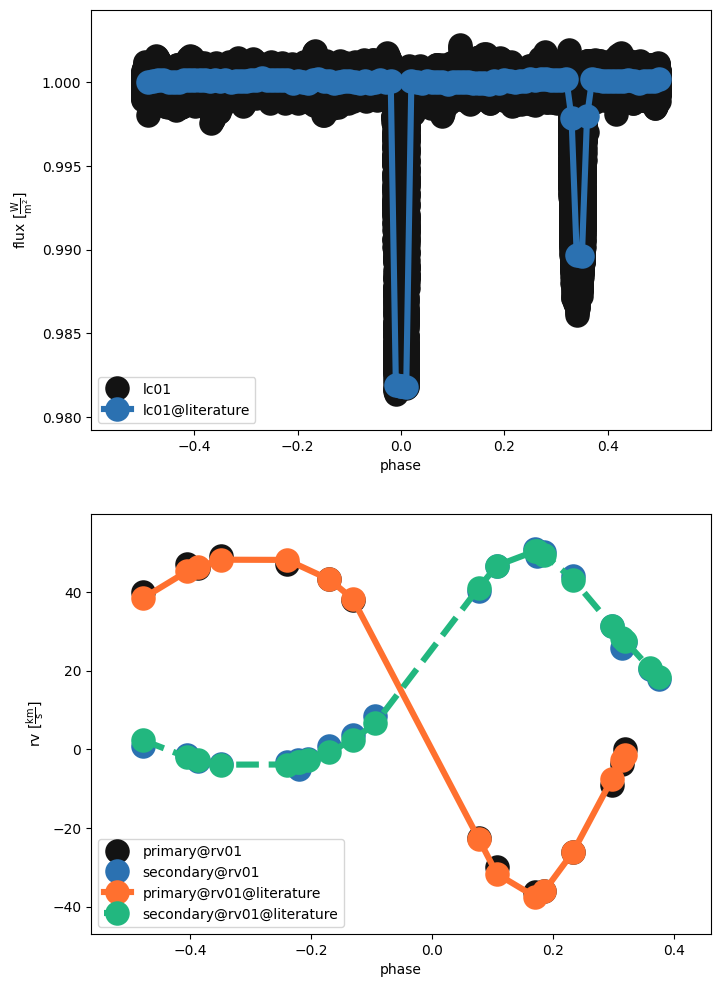

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [6]:
b.run_compute(model='literature',overwrite=True)
b.plot(x='phase', marker='o', legend=True, show=True,model='literature')

Looking at the light curve, I can see that the temperature ratio/radii are still off (from the depths of the eclipses). We will work on this using optimizers.

# Optimizers - Nelder Mead

Now we will fit the model to the data using optimizers. First, we will use a simplified model with basic physics to get the parameter values as close as possible (because this is much faster). Then, we will include more detailed physics to improve the solution (which takes longer per iteration). 

Here we will set the compute parameters and give them the name "optimize_fast". The compute parameters tell PHOEBE which physics should be used to compute the model (i.e. spherical stars or the Roche model). From now on, when I compute a model (run_compute), I will need to specify which compute options I want, that is, how I want the model to be computed. For "optimize_fast" we will be creating a basic model. We will make a different set of compute options when it is time to create a detailed model.

In [7]:
b.add_compute(compute='optimize_fast')

<ParameterSet: 46 parameters | datasets: rv01, _default, lc01>

In [8]:
b.set_value_all('ld_mode', value='interp')
b.set_value_all('atm', value='ck2004')
b.set_value('irrad_method', compute='optimize_fast', value='none')
b.set_value_all('rv_method', compute='optimize_fast', value='dynamical')
b.set_value_all('distortion_method', compute='optimize_fast', value='sphere')

## Fitting with the Nelder Mead optimizer

We will start by fitting the radial velocities. To do this, we will disable the light curve data set:

In [9]:
b.disable_dataset('lc01')
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

To make this quick, we will add compute phases (this will apply to both radial velocities): 

In [10]:
comp_phases = np.linspace(0,1,61)
b.flip_constraint('compute_phases@rv01', solve_for='compute_times@rv01')
b.set_value_all('compute_phases', dataset='rv01', value=comp_phases)

Add the optimizer and tell it to use the compute settings that we have set up:

In [11]:
b.add_solver('optimizer.nelder_mead',  solver='nm', compute='optimize_fast', overwrite=True)

<ParameterSet: 14 parameters | qualifiers: priors_combine, adaptive, initial_values, compute, comments, priors, progress_every_niters, xatol, use_server, continue_from, fatol, fit_parameters, maxiter, expose_lnprobabilities>

Specify how many iterations you want (start with a smaller number, i.e. 50, and increase once things are working):

In [12]:
b.set_value('maxiter', solver='nm', value=50)

Select the parameters you want to fit. Here we must also flip the constraints back so that the parameters we wish to fit are changeable (not constrained):

In [13]:
b.flip_constraint('sma@binary', solve_for='mass@primary') # we do this first to free the semi-major axis so that we can then flip it with asini (which we will fit)
b.flip_constraint('asini@binary', solve_for='sma@binary')
b.flip_constraint(qualifier='q', component='binary', solve_for='mass@secondary')

<ConstraintParameter: {mass@secondary@component} = (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218) (solar units) => 1.3099999999999992 solMass>

Unlike with the estimators, we need to select the parameters we want to fit when using optimizers. Here, we specify which parameters we want to fit to the radial velocity curve:

In [14]:
fit_params = ['vgamma@system', 'q@binary', 'asini@binary','ecc@binary', 'per0@binary']
b.set_value('fit_parameters', fit_params)

Run the solver:

In [15]:
b.run_solver('nm', solution='nm_rv_sol', overwrite=True)

100%|███████████████████████████████████████████| 50/50 [01:38<00:00,  1.96s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_values, initial_values, comments, message, fitted_units, fitted_values, fitted_twigs, success, adopt_distributions, niter, adopt_parameters>

We can check on the reasonableness of the fit with the keyword trial_run = True. This let's us see what the new values are without having to adopt them first. 

In [16]:
print(b.adopt_solution(solution='nm_rv_sol', trial_run=True))

ParameterSet: 5 parameters
                    vgamma@system: 16.051091139743384 km / s
         q@binary@orbit@component: 1.6115278328981435
     asini@binary@orbit@component: 86.99237467413607 solRad
       ecc@binary@orbit@component: 0.2588079519729194
      per0@binary@orbit@component: 168.4211308782645 deg


If the parameters look reasonable; specifically, if they are not nans and the values are not too different from the previous parameter values, we can adopt the solution:

In [17]:
b.adopt_solution(solution='nm_rv_sol')

<ParameterSet: 25 parameters | contexts: dataset, system, component>

We will call this model a different name so that we still have the "literature" model if this one isn't so good.

In [18]:
b.run_compute(compute='optimize_fast',solution='nm_rv_sol', model='nm_rv_mod', overwrite=True)

Thu, 14 Mar 2024 15:24 BUNDLE       WARNING applying passed solution (nm_rv_sol) to sample_from
Thu, 14 Mar 2024 15:24 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_rv_sol=False
Thu, 14 Mar 2024 15:24 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


<ParameterSet: 10 parameters | components: primary, secondary>

Now plot a model to see the new fit:

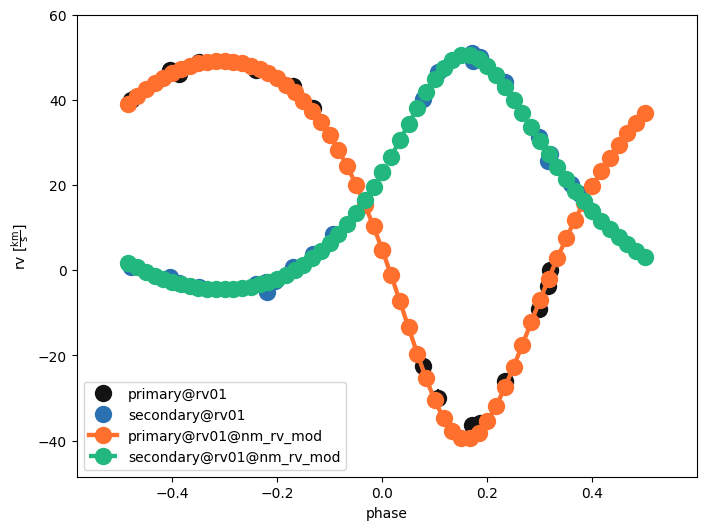

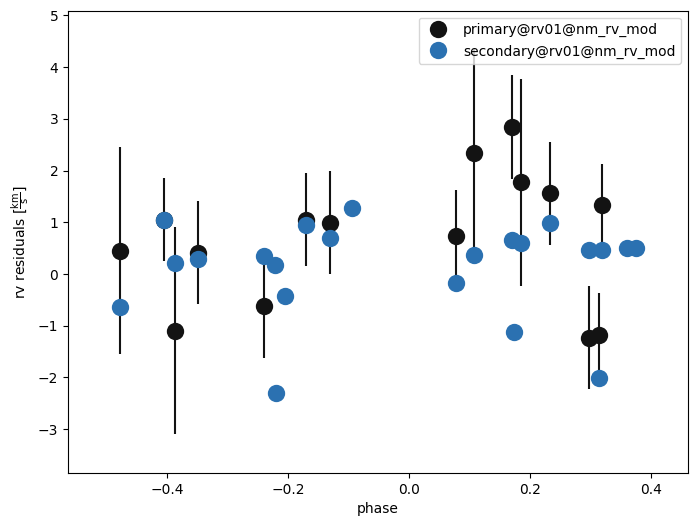

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [19]:
b.plot(kind='rv', model='nm_rv_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='rv', model='nm_rv_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

The solution already looks pretty good so let's save the bundle and move on to fitting the light curves

In [20]:
b.save('bundles/after_nm_rv.bundle')

'bundles/after_nm_rv.bundle'

## Fit the light curve only with Nelder Mead optimizer

First, let's enable the lightcurve data set and compute a model with the light curve. Then plot the model:

In [21]:
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: binary, primary, secondary>

We will also need to increase the number of phases for the light curve computations:

In [22]:
comp_phases = np.linspace(0,1,301)
b.set_value('compute_phases', dataset='lc01', value=comp_phases)

Now let's compute and plot the model with the light curve and radial velocity curve:

Thu, 14 Mar 2024 15:24 BUNDLE       WARNING applying passed solution (nm_rv_sol) to sample_from
Thu, 14 Mar 2024 15:24 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_rv_sol=False
Thu, 14 Mar 2024 15:24 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.45s/it]


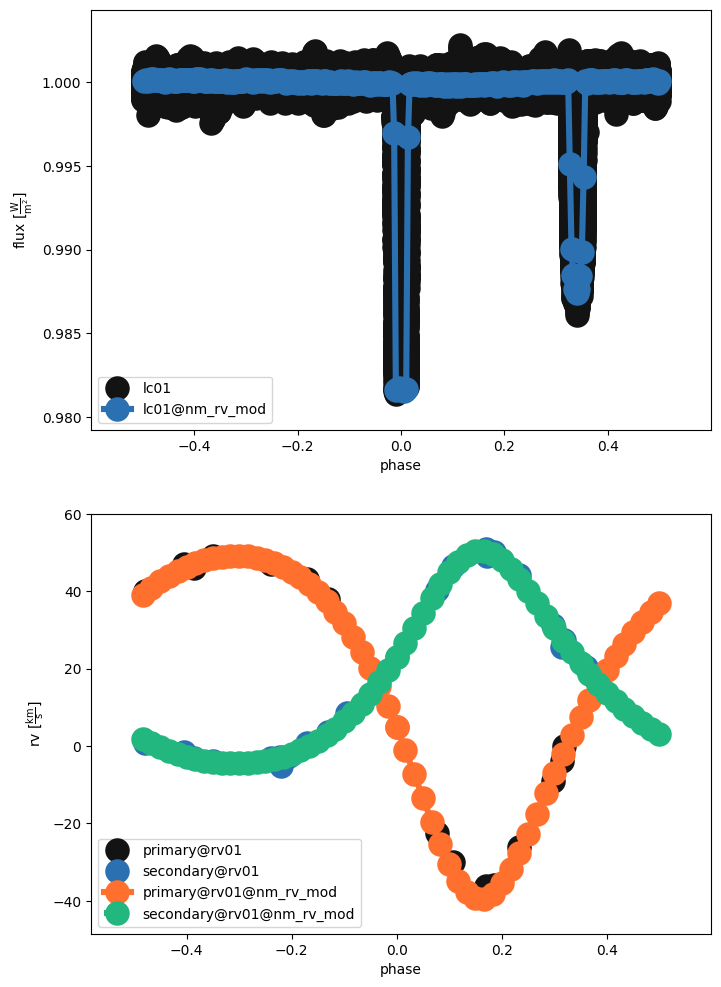

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [23]:
b.run_compute(compute='optimize_fast',solution='nm_rv_sol', model='nm_rv_mod', overwrite=True)
b.plot(model='nm_rv_mod', x='phases', show=True, legend=True, marker = 'o')

The next step is to just optimze the light curve so first we disable the radial velocity curve:

In [24]:
b.disable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

Since the light curve has so many data points, first we will just fit the eclipses. To do this we will mask out the data around the eclipses using the eclipse phases that were identified by LC Geometry:

In [25]:
adopt_parameters = ['mask_phases']
b.set_value(solution = 'lcgeom_sol', qualifier='adopt_parameters', 
            value=adopt_parameters)
b.adopt_solution('lcgeom_sol', adopt_parameters='mask_phases')

<ParameterSet: 1 parameters>

Let's plot the updated lightcurve:

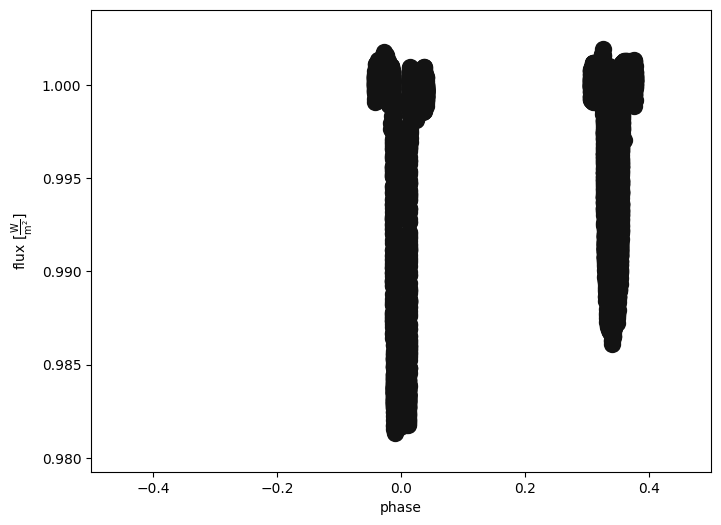

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [26]:
b.plot(kind='lc', model='after_nm', x='phases', xlim=(-0.5,0.5), show='True')

Now we will update the constraints so that we can fit the temperature ratio (instead of individual temperatures). I am solving for the primary (main sequence star) temperature because this is the temperature that I want to be updated automatically when the ratio is adjusted. This way, the red giant temperature (which is better determined) won't change with the new estimate of the temperature ratio.

In [27]:
b.flip_constraint('teffratio@binary', solve_for='teff@primary@component')

<ConstraintParameter: {teff@primary@component} = {teff@secondary@component} / {teffratio@binary@component} (solar units) => 5771.0 K>

Again, we need to select the parameters to be fitted, but this time we want to fit the parameters that have information in the light curve:

In [28]:
fit_params = ['teffratio@binary', 'incl@binary', 'requiv@secondary']
b.set_value('fit_parameters', fit_params)

Set the maximum number of iterations:

In [29]:
b.set_value('maxiter', solver='nm', value=100)

Run the solver:

In [30]:
b.run_solver(solver='nm', compute='optimize_fast', solution='nm_lc_sol', overwrite=True)

100%|█████████████████████████████████████████| 100/100 [07:30<00:00,  4.51s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_values, initial_values, comments, message, fitted_units, fitted_values, fitted_twigs, success, adopt_distributions, niter, adopt_parameters>

First take a look at the parameters without adopting them using "trial run":

In [31]:
print(b.adopt_solution('nm_lc_sol', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.8789397621133672
      incl@binary@orbit@component: 90.88148006506032 deg
   requiv@secondary@star@compo...: 7.768817840235274 solRad


If the solution looks good (there are no nans or numbers that are unexpected), we can adopt it. Note here that the inclination wraps at 90 degs and so if the value is over 90, the value is the same as 180-incl.

In [32]:
b.adopt_solution('nm_lc_sol')

<ParameterSet: 19 parameters | kinds: star, orbit>

Compute the model with the new solution and plot it to see what it looks like:

In [33]:
b.run_compute(compute='optimize_fast', solution='nm_lc_sol', model='nm_lc_mod', overwrite=True)

Thu, 14 Mar 2024 15:32 BUNDLE       WARNING applying passed solution (nm_lc_sol) to sample_from
Thu, 14 Mar 2024 15:32 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol=False
Thu, 14 Mar 2024 15:32 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.27s/it]


<ParameterSet: 9 parameters | qualifiers: samples, comments, times, sample_mode, fluxes, flux_scale, sampled_uniqueids, sampled_twigs, failed_samples>

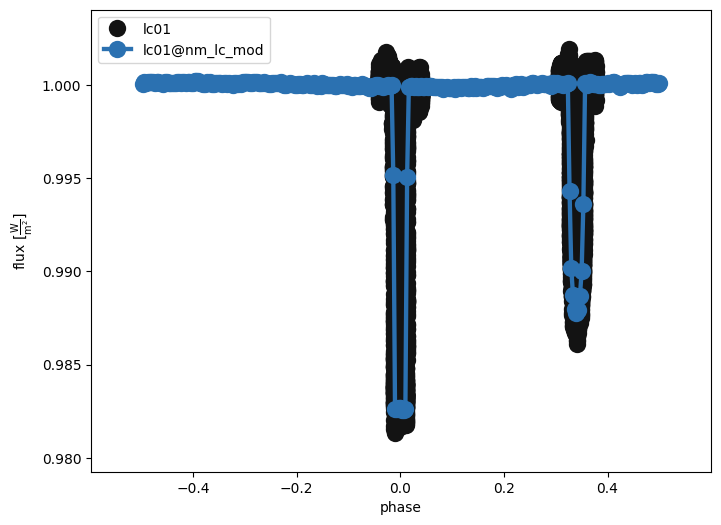

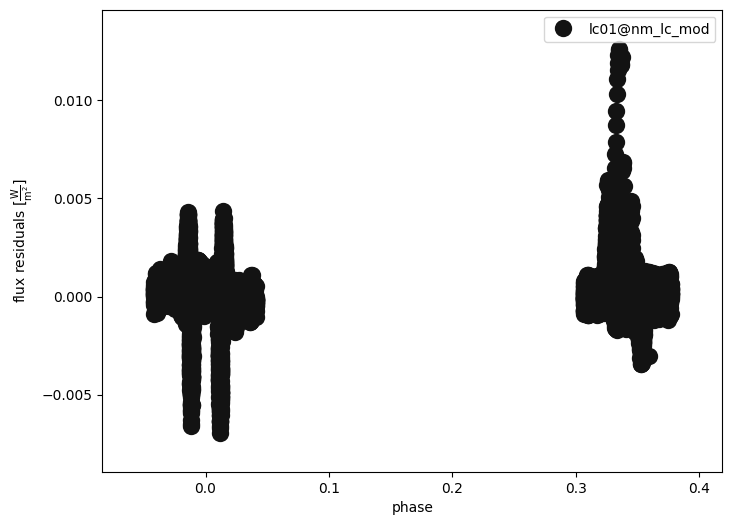

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [34]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

We can also look at the individual eclipses to see how they are fitting:

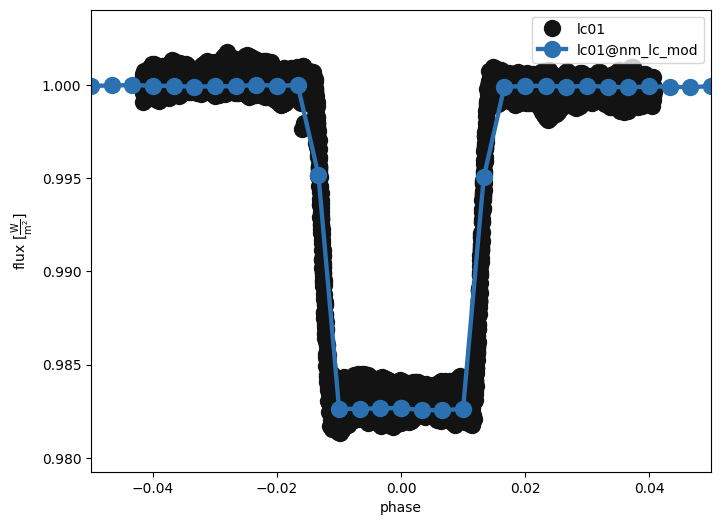

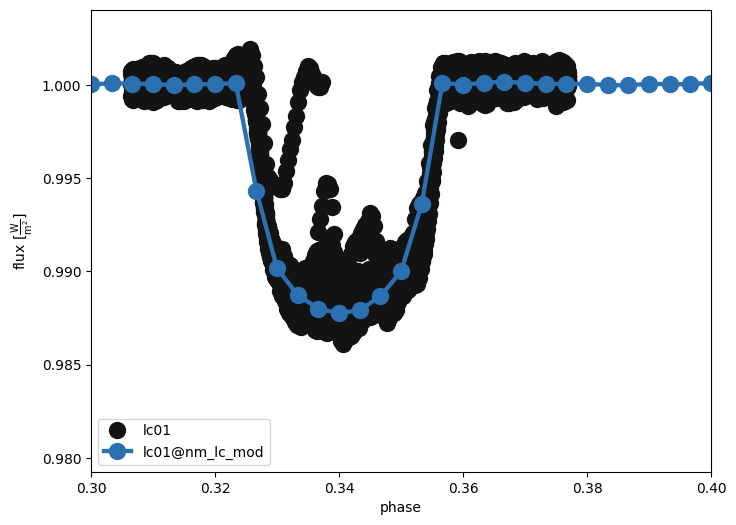

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [35]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o', xlim=(-0.05,0.05))
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o', xlim=(0.3,0.4))

The plots show that the number of data points covering the eclipses is on the low side. We can fix this by increasing the number of compute phases for the light curve:

In [39]:
comp_phases = np.linspace(0,1,501)
b.set_value('compute_phases', dataset='lc01', value=comp_phases)

Additionally, the secondary eclipse shape (the less deep eclipse) is slightly skewed and too wide. The skewness and width of the eclipses is a function of the argument of periastron, per0, and eccentricity, ecc. We update our fitted parameters to include these parameters. We can also fit the sum and fractions of the radii, which are better defined in the lightcurve (orthogonal):

In [41]:
b.flip_constraint('requivsumfrac@binary', solve_for='requiv@primary')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
fit_params = ['teffratio@binary', 'requivsumfrac@binary','requivratio','ecc','per0']#'incl@binary'
b.set_value('fit_parameters', fit_params)

Run the solver on the newly selected parameters:

In [42]:
b.run_solver(solver='nm', solution='nm_lc_sol',compute='optimize_fast', overwrite=True)

Thu, 14 Mar 2024 16:46 BUNDLE       WARNING fit_parameters contains a parameter (['per0']) that affects phasing which could cause issues with mask_phases
100%|█████████████████████████████████████████| 100/100 [09:08<00:00,  5.49s/it]


<ParameterSet: 11 parameters | qualifiers: adopt_values, initial_values, comments, message, fitted_units, fitted_values, fitted_twigs, success, adopt_distributions, niter, adopt_parameters>

First take a look at the parameter values without adopting them using "trial run":

In [43]:
print(b.adopt_solution(solution='nm_lc_sol', trial_run=True))

ParameterSet: 5 parameters
   teffratio@binary@orbit@comp...: 0.8787640620921371
   requivsumfrac@binary@orbit@...: 0.09758205621059167
   requivratio@binary@orbit@co...: 10.247982801605536
       ecc@binary@orbit@component: 0.2573785588130818
      per0@binary@orbit@component: 168.10173890714609 deg


Adopt the parameters if the values look reasonable:

In [44]:
b.adopt_solution(solution='nm_lc_sol')

<ParameterSet: 19 parameters | contexts: dataset, component>

Compute the model and plot it:

Thu, 14 Mar 2024 16:56 BUNDLE       WARNING applying passed solution (nm_lc_sol) to sample_from
Thu, 14 Mar 2024 16:56 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol=False
Thu, 14 Mar 2024 16:56 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


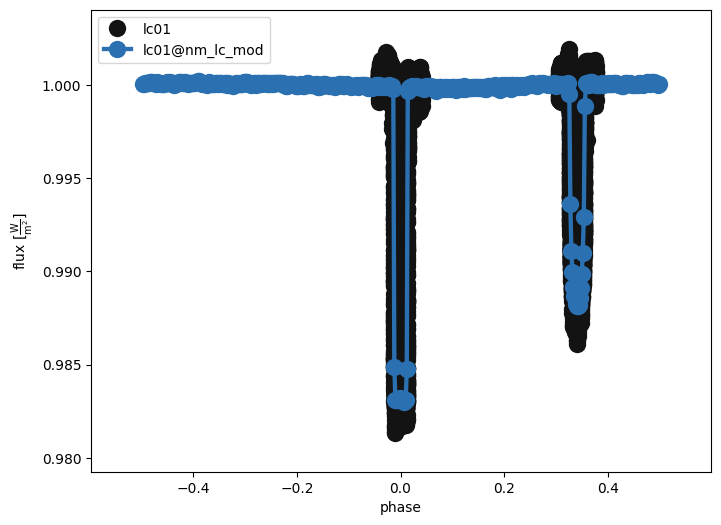

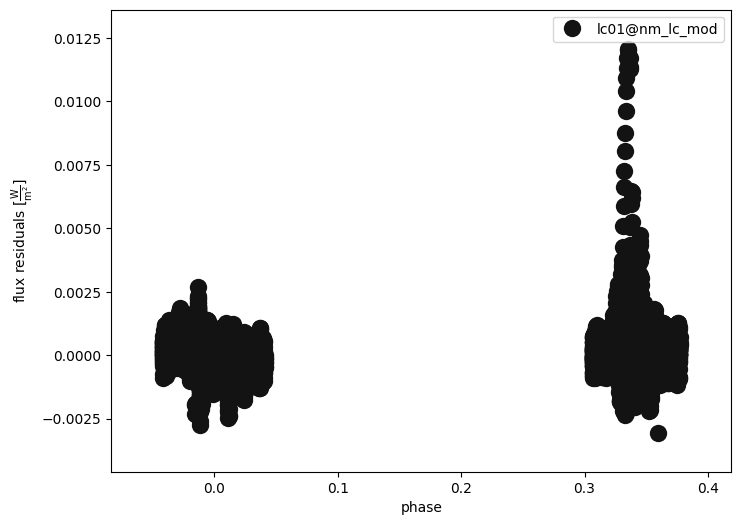

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [45]:
b.run_compute(compute='optimize_fast', solution='nm_lc_sol', model='nm_lc_mod',overwrite=True)

b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

Plot the eclipses to see if there has been any improvement:

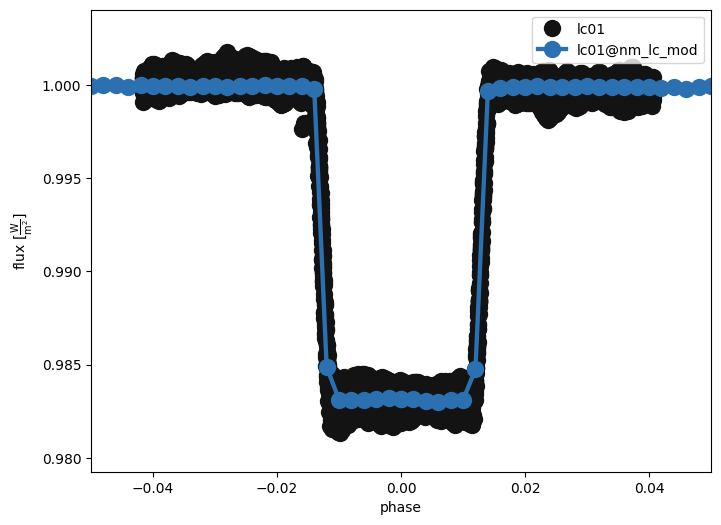

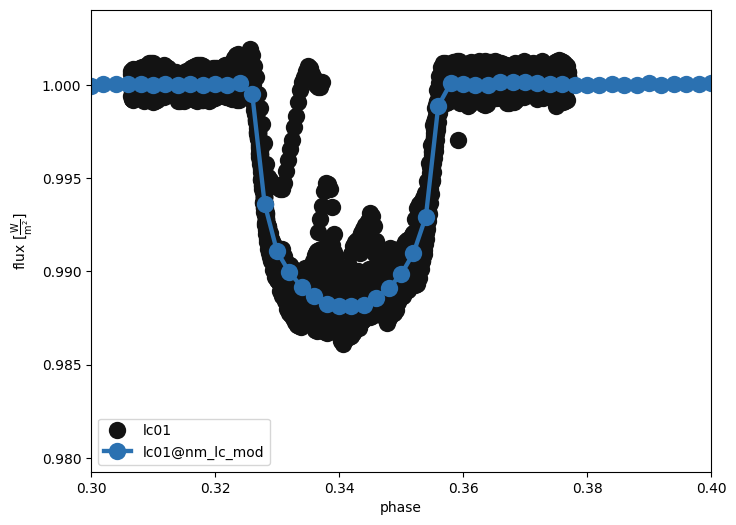

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [46]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o', xlim=(-0.05,0.05))
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o', xlim=(0.3,0.4))

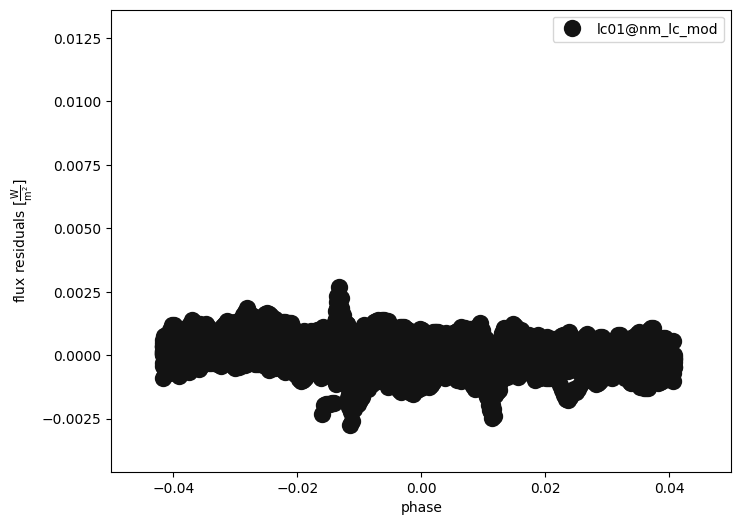

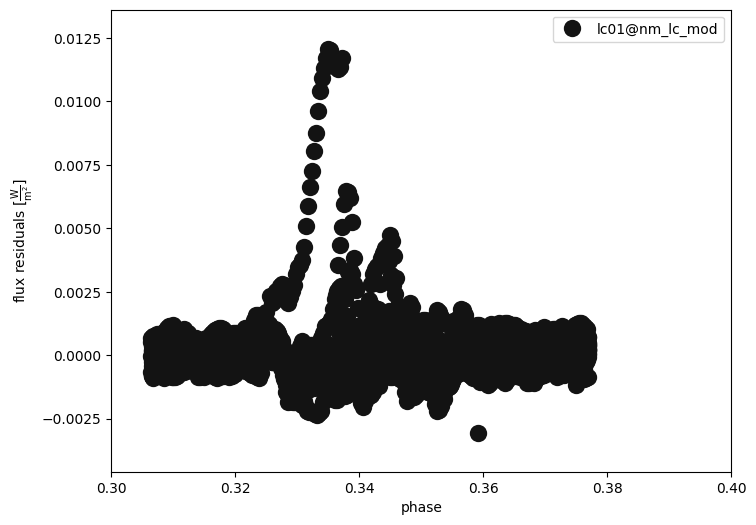

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [47]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o', xlim=(-0.05,0.05))
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o', xlim=(0.3,0.4))

These plots show significant improvement. The weird variations in the secondary eclipses are causing the residuals (not a bad model fit. To first order, the fit is good. 

Let's now take a look at the radial velocity and light curve solutions. To do this, we enable the radial velocity data set:

In [48]:
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, primary, secondary>

We will need to run the model again and then plot the models:

Fri, 15 Mar 2024 11:02 BUNDLE       WARNING applying passed solution (nm_lc_sol) to sample_from
Fri, 15 Mar 2024 11:02 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol=False
Fri, 15 Mar 2024 11:02 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


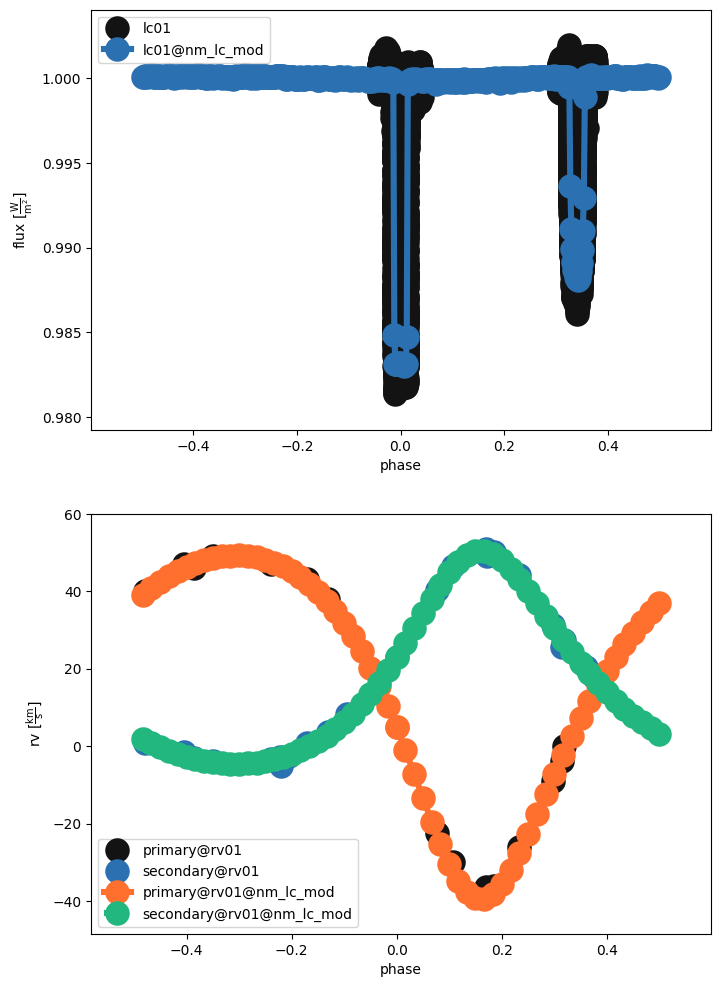

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [63]:
b.run_compute(compute='optimize_fast', solution='nm_lc_sol', model='nm_lc_mod', overwrite=True)
b.plot(model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')

Now, let's plot all the models to see the differences:

/usr/local/lib/python3.10/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


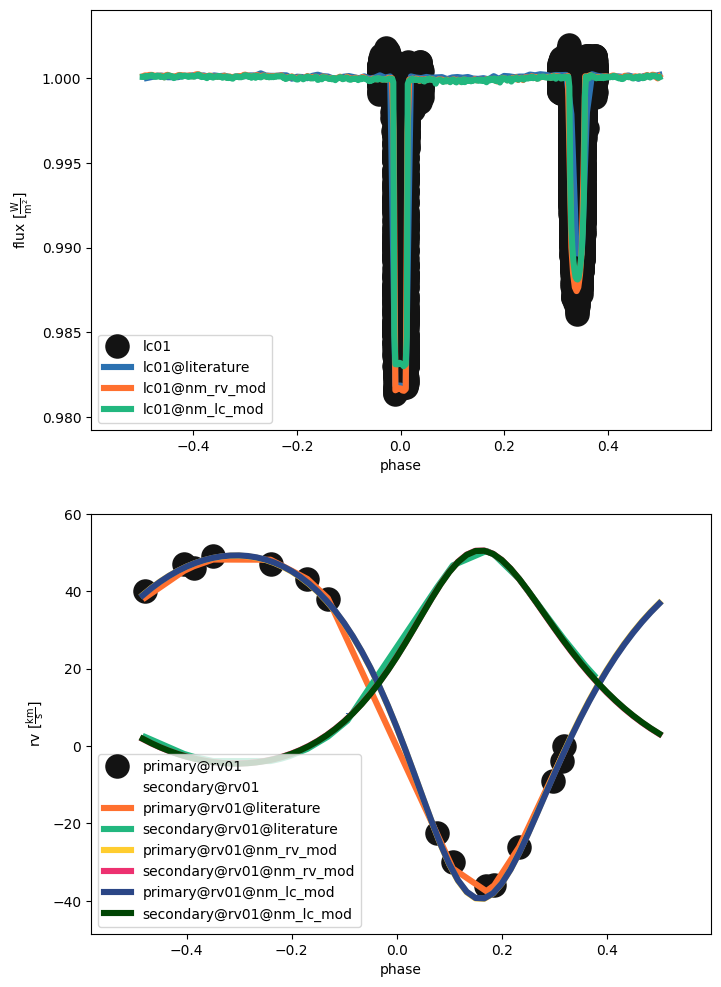

(<autofig.figure.Figure | 2 axes | 12 call(s)>,
 <Figure size 800x1200 with 2 Axes>)

In [61]:
b.plot(model=['nm_lc_mod','literature','nm_rv_mod'],x='phases', show=True, ls='-', legend=True)

Given the good fit with a basic model, it's now time to include more advanced physics. Let's save the note book and model the data in a more advanced way. 

In [54]:
b.save('bundles/after_nm_fast.bundle')

'bundles/after_nm_fast.bundle'